#  Time Series Analysis of BXD Aging Colony Body Weight

The BXD family of mice is a recombinant inbred strain of mice which can be reproduced by crossing a female C57BL/6J (B6 or B) and a male DBA/ 2J (D2 or D).  They are used to map Mendelian and Trait Loci.

In this explorative exercise, we apply some time series analysis to investigate body weight across several months of collected data.  We first do some data cleaning, and from the various data points, pick one experiment(represented as one vector) to model and attempt forecasting.

The dataset provided in this exercise was provided by [Prof Roy Suheeta](https://www.researchgate.net/profile/Suheeta-Roy)

### Data Cleaning

The first part of this exercise is to store the data in a panda's data frame; remove metadata that is useless; and reshape some of the titles to make visualisation easier.

We first get an overview of what this dataset looks like:

In [3]:
import pandas as pd

df = pd.read_excel("BXD_BodyWeights_12Nov2021.xlsx", header=[3])
print(f"Columns:\n{' '.join(df.columns)}")
print(f"\nCount of individual columns:\n{df.count()}")
df.head()

Columns:
EarTagNumberCurrent EarTagNumberOriginal StrainName Sex Diet CauseOfDeath AgeAtDeath DateOfBirth DateOfDeath DateDietStart Age diet started Weight00Baseline Weight01 Weight02 Weight03 Weight04 Weight05 Weight06 Weight07 Weight08 Weight09 Weight10 Weight11 Weight12 Weight13 Weight14 Weight15 Weight16 Weight17 Weight18

Count of individual columns:
EarTagNumberCurrent     2506
EarTagNumberOriginal    2506
StrainName              2506
Sex                     2506
Diet                    2506
CauseOfDeath            2506
AgeAtDeath              2505
DateOfBirth             2506
DateOfDeath             2505
DateDietStart           2506
Age diet started        2506
Weight00Baseline        2506
Weight01                2473
Weight02                2266
Weight03                2160
Weight04                1939
Weight05                1639
Weight06                1423
Weight07                1100
Weight08                 824
Weight09                 629
Weight10                 416
Weig

,EarTagNumberCurrent,EarTagNumberOriginal,StrainName,Sex,Diet,CauseOfDeath,AgeAtDeath,DateOfBirth,DateOfDeath,DateDietStart,...,Weight09,Weight10,Weight11,Weight12,Weight13,Weight14,Weight15,Weight16,Weight17,Weight18
0,1231,1231,B6D2F1,F,CD,Other,193.0,2013-02-03,2013-08-15,2013-08-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1570,1537,B6D2F1,F,CD,Natural,880.0,2013-07-27,2015-12-24,2014-04-11,...,31.3,21.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2281,2281,B6D2F1,F,CD,Natural,879.0,2015-04-28,2017-09-23,2015-08-05,...,38.7,39.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2282,2282,B6D2F1,F,CD,Natural,992.0,2015-04-28,2018-01-14,2015-08-05,...,41.5,40.6,33.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2283,2283,B6D2F1,F,CD,Natural,912.0,2015-04-28,2017-10-26,2015-08-05,...,37.7,39.5,38.0,35.7,NaN,NaN,NaN,NaN,NaN,NaN


From the above, it's immediately obvious that data collection happened over the span of 18 months, with some experiments-- represented by a single row, running for less than the aforementioned 18 months.  One task, is to determine a minimum threshold for which to conduct our analysis.  With regards to this, for this analysis, experirements that have less than 15 data points are filtered out.

In [4]:
df = df.dropna(thresh=df.shape[1]-3)
print(f"\nCount of individual columns:\n{df.count()}")


Count of individual columns:
EarTagNumberCurrent     16
EarTagNumberOriginal    16
StrainName              16
Sex                     16
Diet                    16
CauseOfDeath            16
AgeAtDeath              16
DateOfBirth             16
DateOfDeath             16
DateDietStart           16
Age diet started        16
Weight00Baseline        16
Weight01                16
Weight02                16
Weight03                16
Weight04                16
Weight05                16
Weight06                16
Weight07                16
Weight08                16
Weight09                16
Weight10                16
Weight11                16
Weight12                16
Weight13                16
Weight14                16
Weight15                16
Weight16                 8
Weight17                 4
Weight18                 1
dtype: int64


Each month's entry is represented under "Weight**".  With this in mind, we use these columns to represent a time entry by renaming these columns into an index.  "Weight00" becomes "0", "Weight01" becomes "1", and so forth.

In [22]:
def rename_columns(name: str) -> str:
    name = name.replace("Weight", "").replace("Baseline", "")
    if name.isdigit():
        return str(int(name))
    return name

df = df.rename(columns=rename_columns)
print(f"Columns:\n{' '.join(df.columns)}")
df.head()

Columns:
EarTagNumberCurrent EarTagNumberOriginal StrainName Sex Diet CauseOfDeath AgeAtDeath DateOfBirth DateOfDeath DateDietStart Age diet started 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 identifier


,EarTagNumberCurrent,EarTagNumberOriginal,StrainName,Sex,Diet,CauseOfDeath,AgeAtDeath,DateOfBirth,DateOfDeath,DateDietStart,...,10,11,12,13,14,15,16,17,18,identifier
19,2817,2817,BXD1,F,CD,Euthanized,1007.0,2018-04-24,2021-01-25,2018-07-12,...,29.6,30.4,29.0,28.2,27.7,26.5,NaN,NaN,NaN,2817-BXD1-F-CD-Euthanized
179,2228,2228,BXD168,F,CD,Natural,1092.0,2015-06-24,2018-06-20,2015-08-05,...,24.8,28.2,24.9,26.3,23.9,20.9,19.9,NaN,NaN,2228-BXD168-F-CD-Natural
190,2667,2667,BXD168,F,CD,Euthanized,999.0,2016-12-04,2019-08-30,2017-02-24,...,32.8,33.9,33.8,29.1,27.8,28.1,NaN,NaN,NaN,2667-BXD168-F-CD-Euthanized
230,2306,2306,BXD175,F,CD,Natural,1091.0,2015-07-10,2018-07-05,2015-09-09,...,21.2,17.2,17.2,16.2,14.3,14.5,13.6,NaN,NaN,2306-BXD175-F-CD-Natural
273,2210,2210,BXD19,F,CD,Natural,1068.0,2015-06-09,2018-05-12,2015-08-05,...,28.0,28.4,23.8,23.2,21.3,18.9,NaN,NaN,NaN,2210-BXD19-F-CD-Natural


Next, we collapse various columns that contain metadata into one column.

In [49]:
columns = ["EarTagNumberOriginal", "StrainName", "Sex", "Diet", "CauseOfDeath"]

df["identifier"] = df[columns].apply(
    lambda row: "-".join(row.values.astype(str)), axis=1)

weights = df.drop(df.columns[[i for i in range(0, 11)]],
                       axis=1).set_index("identifier")

weights.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
identifier,,,,,,,,,,,,,,,,,,,
2817-BXD1-F-CD-Euthanized,20.1,27.0,32.6,30.8,30.8,29.2,28.8,27.7,30.2,31.2,29.6,30.4,29.0,28.2,27.7,26.5,NaN,NaN,NaN
2228-BXD168-F-CD-Natural,15.4,20.4,23.1,24.7,26.5,27.0,27.1,25.9,25.3,24.9,24.8,28.2,24.9,26.3,23.9,20.9,19.9,NaN,NaN
2667-BXD168-F-CD-Euthanized,20.6,23.7,26.8,30.8,27.7,28.5,29.3,31.2,31.3,32.4,32.8,33.9,33.8,29.1,27.8,28.1,NaN,NaN,NaN
2306-BXD175-F-CD-Natural,16.2,17.2,19.0,19.6,19.6,20.3,22.0,22.6,22.5,21.3,21.2,17.2,17.2,16.2,14.3,14.5,13.6,NaN,NaN
2210-BXD19-F-CD-Natural,19.2,29.1,29.9,32.5,32.4,30.6,32.4,29.5,28.3,29.1,28.0,28.4,23.8,23.2,21.3,18.9,NaN,NaN,NaN


### Visualisation And Analysis

We make a time series plot for every row in the same figure:

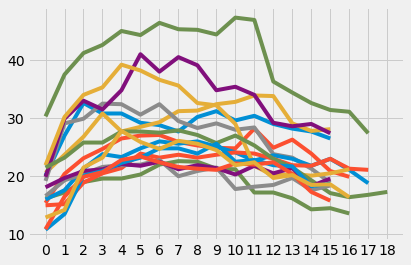

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.plot(weights.transpose())

From the above, we can see that all the BXD colonies seem similar in shape.  To make our analysis easier, we choose one experiment, and in this case, we opt for one which has no missing entry(that is, one that ran for a period of 18 months):

identifier,2534-BXD29-F-CD-Natural
0,21.5
1,23.2
2,25.8
3,25.8
4,27.7


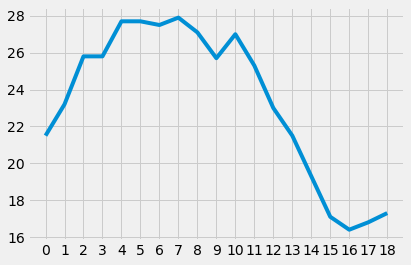

In [57]:
single_bxd = weights.dropna(thresh=weights.shape[1]-0).transpose()
plt.plot(single_bxd)
single_bxd.head()

In [58]:
single_bxd["2534-BXD29-F-CD-Natural"]

0     21.5
1     23.2
2     25.8
3     25.8
4     27.7
5     27.7
6     27.5
7     27.9
8     27.1
9     25.7
10    27.0
11    25.3
12    23.0
13    21.5
14    19.3
15    17.1
16    16.4
17    16.8
18    17.3
Name: 2534-BXD29-F-CD-Natural, dtype: float64

Here, we try to model the time series as an additive time series[1]:

```
Value = Base Level + Trend + Seasonality + Error  
```

Text(0.5, 0.98, 'Additive Decompose')

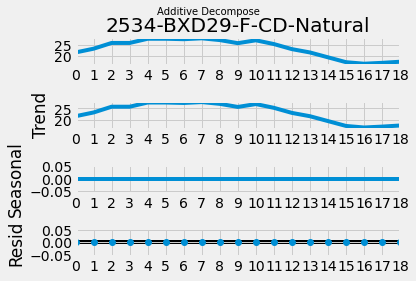

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

bxd_additive = seasonal_decompose(single_bxd.iloc[:,0],
                                  period=1,
                                  model='additive')
bxd_additive.plot().suptitle("Additive Decompose", fontsize=10)

Here, we try to model the time series as a multiplicative time series:

```
Value = Base Level * Trend * Seasonality * Error    
```

We perform an Augmented Dickey Fuller (ADF)[2] Test to check whether the series is stationary or not:

In [60]:
from statsmodels.tsa.stattools import adfuller

def print_test_statistics(values):
    result = adfuller(values)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    
print_test_statistics(values=single_bxd.iloc[:,0].values)

ADF Statistic: -0.0544396646351928
p-value: 0.9537916493653631
Critial Values:
   1%, -3.859073285322359
Critial Values:
   5%, -3.0420456927297668
Critial Values:
   10%, -2.6609064197530863


From the above, the obtained p-value is greater than significance level of 0.05 and the ADF statistic is greater than any of the critical values.  We therefore do not reject the null hypothesis, and we can conclude that this series is non-stationary.

The next step in our analysis is to try to make this series stationary, and we first try to do this by differencing:

ADF Statistic: -963.6122928751103
p-value: 0.0
Critial Values:
   1%, -4.331573
Critial Values:
   5%, -3.23295
Critial Values:
   10%, -2.7487


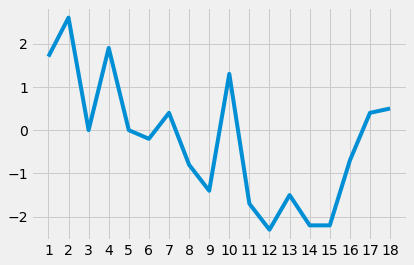

In [61]:
diffed_single_bxd = single_bxd.diff().dropna()
plt.plot(diffed_single_bxd)

print_test_statistics(diffed_single_bxd.iloc[:,0].values)

From the above, we see that differencing once made the time series stationary because the p-value is less than 0.05 and the ADF statistic is less than all the critical values.  Next, we plot the PACF and ACF to help us determine which model(AR[I]MA(p,q), AR(p), MA(q)) model to fit:

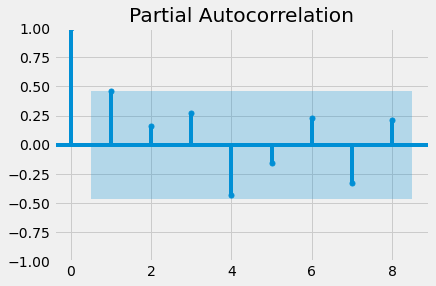

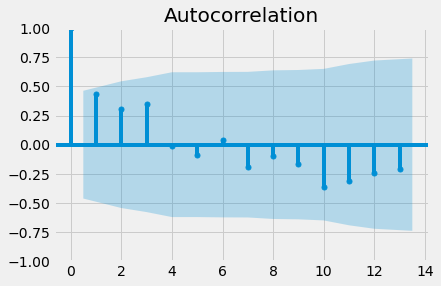

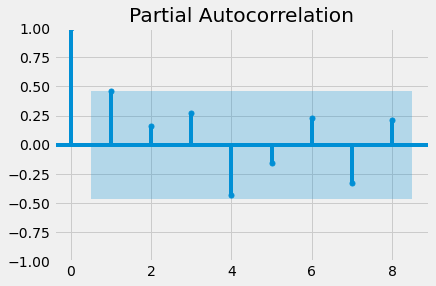

In [62]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diffed_single_bxd)
plot_pacf(diffed_single_bxd, lags=8, method="yw")

From the above, we see a tail-off at the ACF plot, and a cut-off at lag 1 in the PACF.  This indicates an AR(1) process of the form:

x<sub>t</sub> = ϕ<sub>0</sub>x<sub>0</sub> + ϕ<sub>1</sub>x<sub>t-1</sub> + ω<sub>t-1</sub> + μ

We can now use Yule Walker equations to get the value of ϕ.  For this, we split the data into a training and test set, so that we can perform how our model performs:

In [63]:
from statsmodels.tsa.ar_model import AutoReg
X = diffed_single_bxd.iloc[:,0].values
train, test = X[0:len(X)-5], X[len(X)-5:]
model_fit = AutoReg(train, lags=1).fit()
print(f'Coefficients: {model_fit.params}')

Coefficients: [-0.183827   0.3372827]


We thereafter inspect the errors from our model:

In [64]:
predictions = model_fit.predict(start=len(train),
                                end=len(train)+len(test)-1,
                                dynamic=False)
for i in range(len(predictions)):
    print(f"Error: {abs(predictions[i] - test[i])}")

Error: 1.5102489398206589
Error: 1.7835318929135164
Error: 0.3757055062078283
Error: 0.6932059282904643
Error: 0.7827202928638868


We use the root mean square error to see how our model performs:

In [66]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.157


And finally we plot how predicted values against the actual values

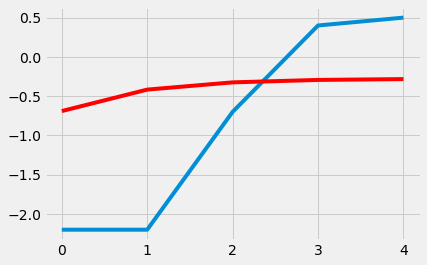

In [68]:
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Conclusion

In this data-exploration exercise, we obtained real world data on BXD Mouse colonies which were represented in excel format as vectors.  We extracted the longest running experiment and did some time series analysis on it.  For this chosen experiment, the data was non-stationary, and we had to difference it once to make it stationary.  The PACF and ACF plots of the differenced data allowed us to infer that this data could be modelled using an AR(1) process.  As an exercise in forecasting, the experiment was split into a test and train data set, and used in forecasting.  The results were satisfactory, albeit 18 data points being too little to make a definite conclusion.  In conclusion, this exercise shows that an AR(1) process can be used to model the aging process of a mouse colony.

## Future Work

There were 2506 experiments in this data set and only one was chosen.  Coming up with a generalized model that performs well, if feasible, for all this experiments should be explored.  This would prove useful to researchers as an extra quality control check after completing an experiment, before uploading their data, for example, to a website like www.genenetwork.org.

## References

[0] Ashbrook, D. G., Arends, D., Prins, P., Mulligan, M. K., Roy, S., Williams, E. G., ... & Williams, R. W. (2021). A platform for experimental precision medicine: the extended BXD mouse family. Cell Syst 12 (3): 235-247. e9.

[1] Time Series Analysis in Python – A Comprehensive Guide with Examples. Dec. 27, 2021. url: https://www.machinelearningplus.com/time-series/time-series-analysis-python/

[2] Augmented Dickey Fuller Test (ADF Test) – Must Read Guide. Dec 28, 2021. url:https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

# Appendix
### Using GNU/ GUIX To Manage Dependencies

In this exercise, [GNU Guix](https://guix.gnu.org/) was used to handle dependencies.  The following manifest file was used:

```
(specifications->manifest
 '("python-matplotlib"
   "python-notebook"
   "python-numpy"
   "python-pandas"
   "python-scikit-learn"
   "python-scipy"
   "python-seaborn"
   "python-statsmodels"
   "python-wrapper"))
```

This file was saved in a `manifest.scm` file and loaded with `guix shell -m manifest.scm`.  The command used to start the notebook file was: `jupyter notebook --ip=0.0.0.0 --port=8080`